In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path
import glob

In [22]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_Isigma_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        sigma = peak.getCorrectedIntensity().sigma()
        qs.append(q)
        Is.append(I/sigma)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()    
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        preds = predictor.predictPeaks([nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2]))], uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = np.linalg.norm(obs_x - preds[0].getShape().center())
        
        if (dx > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx)
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'D19')
diff = expt.getDiffractometer()

data_dir = path.expanduser("~/data/d19/reference_data/thom/y-corrected-data/")
data_files = glob.glob(data_dir + "*.h5")

numors = []

for f in data_files:
    reader = nsx.HDF5DataReader(f,diff)
    # Discard the data with a low number of frames (unlikely to be "production" data)
    if (reader.getNFrames() < 900):
        continue

    # Build the dataset
    data = nsx.DataSet(reader,diff)

    # Add the data to the experiment
    expt.addData(data)

    numors.append(data)

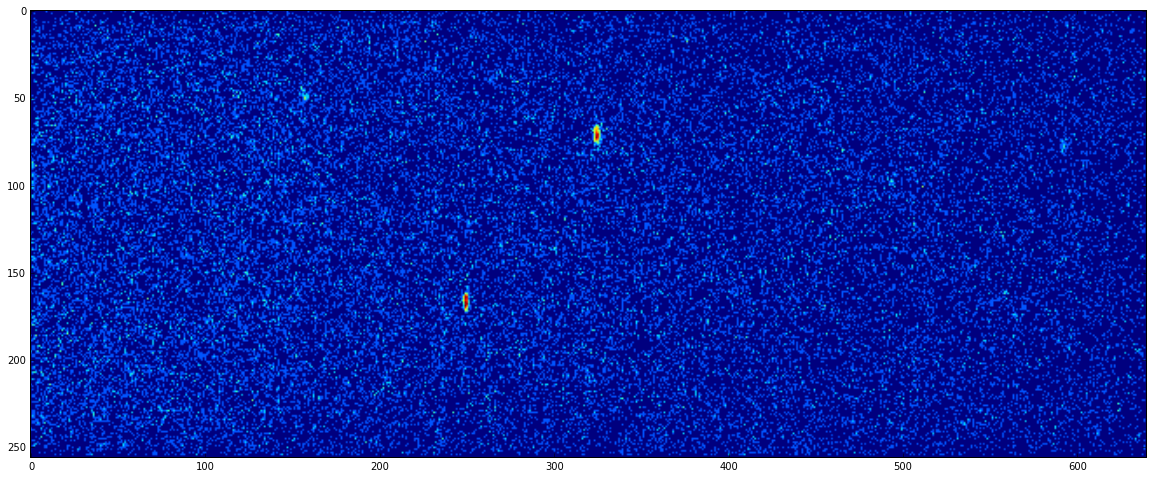

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(1+numors[0].getFrame(100)))
plt.show()

nrows = numors[0].getNRows()
ncols = numors[0].getNCols()

In [5]:
kernel = nsx.AnnularKernel(nrows, ncols)
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(0.4)
finder.setKernel(kernel)

In [7]:
num_numors = len(numors)
peaks = finder.find(numors)
print(peaks.size())
len(numors)

5985


21

In [8]:
for peak in peaks:
       
    inten = peak.getCorrectedIntensity()
    
    if not peak.isSelected():
        continue
    
    if (inten.sigma() < 1.0):
        peak.setSelected(False)

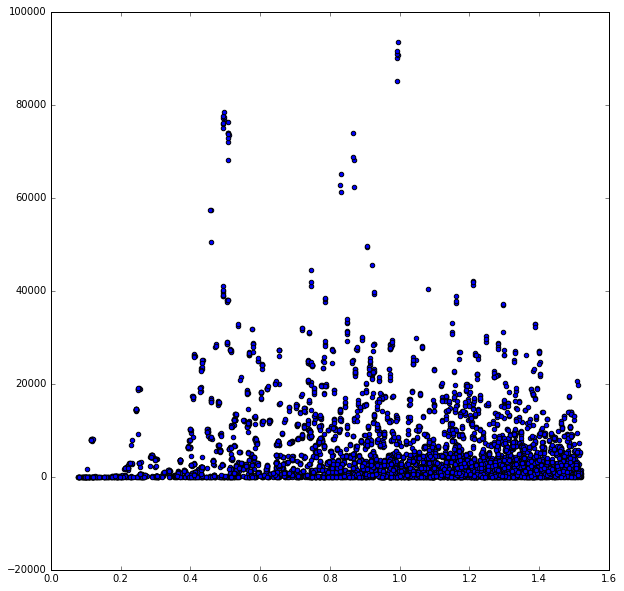

In [9]:
plot_I_vs_q(peaks)

5308


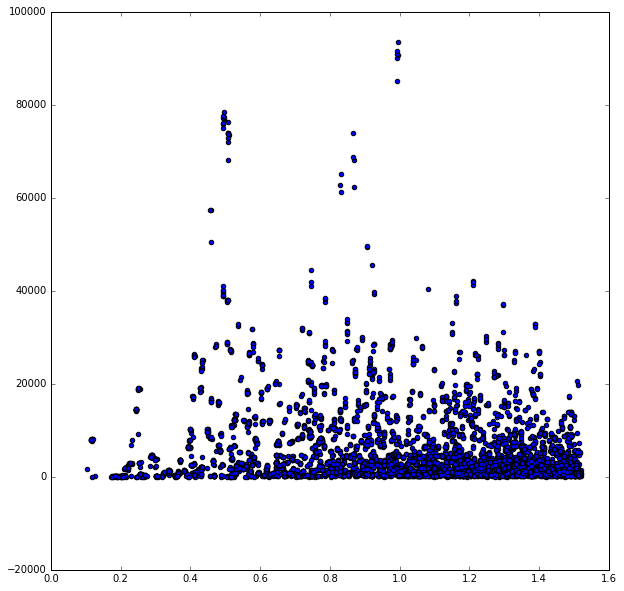

In [10]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 10.0 or d < 0.65:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [11]:
####################################
# AUTO-INDEXING
####################################

indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

params = nsx.IndexerParameters()
indexer.autoIndex(params)

solutions = indexer.getSolutions()

cell_parameters = []

for idx, (uc,score) in enumerate(solutions):

    a     = uc.character().a
    b     = uc.character().b
    c     = uc.character().c
    alpha = np.rad2deg(uc.character().alpha)
    beta  = np.rad2deg(uc.character().beta)
    gamma = np.rad2deg(uc.character().gamma)

    cell_parameters.append((idx,a,b,c,alpha,beta,gamma,score))

    print("idx: {0:3d} --- a = {1:6.2f}  b = {2:6.2f}  c = {3:6.2f}  alpha = {4:6.2f}  beta = {5:6.2f}  gamma = {6:6.2f} --- % indexed = {7:5.2f}".format(*(cell_parameters[-1])))


idx:   0 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.41  gamma =  90.00 --- % indexed = 99.57
idx:   1 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.42  gamma =  90.00 --- % indexed = 99.57
idx:   2 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.42  gamma =  90.00 --- % indexed = 99.57
idx:   3 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.41  gamma =  90.00 --- % indexed = 99.57
idx:   4 --- a =   5.58  b =   5.55  c =  16.19  alpha =  90.00  beta =  83.57  gamma =  90.00 --- % indexed = 99.55
idx:   5 --- a =   5.58  b =  11.09  c =  17.10  alpha =  71.10  beta =  83.92  gamma =  89.95 --- % indexed = 99.53
idx:   6 --- a =   5.58  b =   5.55  c =  16.20  alpha =  90.00  beta =  96.39  gamma =  90.00 --- % indexed = 99.51
idx:   7 --- a =  11.15  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.41  gamma =  90.00 --- % indexed = 99.47
idx:   8 --- a =  11.16  b =   5.55  c =  16.19  alpha =  90.00 

In [12]:
# take best unit cell
uc = solutions[0][0]

for peak in good_peaks:
    peak.addUnitCell(uc, True)

In [13]:
####################################
# SPACE-GROUP
####################################

compatible_space_groups = uc.compatibleSpaceGroups()

hkls = nsx.MillerIndexList()

for peak in good_peaks:
    hkls.push_back(uc.getIntegerMillerIndices(peak.getQ()))

space_groups = []
for idx,symbol in enumerate(compatible_space_groups):
    sg = nsx.SpaceGroup(symbol)
    space_groups.append((idx,symbol,100.0*(1.0-sg.fractionExtinct(hkls))))
    print("idx: {0:3d} --- symbol = {1:10s}  --- % non-extincted peaks = {2:6.2f}".format(*(space_groups[-1])))

idx:   0 --- symbol = P 2         --- % non-extincted peaks = 100.00
idx:   1 --- symbol = P 21        --- % non-extincted peaks =  99.98
idx:   2 --- symbol = P m         --- % non-extincted peaks = 100.00
idx:   3 --- symbol = P c         --- % non-extincted peaks =  99.91
idx:   4 --- symbol = P 2/m       --- % non-extincted peaks = 100.00
idx:   5 --- symbol = P 21/m      --- % non-extincted peaks =  99.98
idx:   6 --- symbol = P 2/c       --- % non-extincted peaks =  99.91
idx:   7 --- symbol = P 21/c      --- % non-extincted peaks =  99.89


In [14]:
peak_set = nsx.PeakSet()

for peak in good_peaks:
    peak_set.insert(peak)

for data in numors:
    data.integratePeaks(peak_set, 5.0, 8.0, nsx.ProgressHandler())
    
compute_statistics(good_peaks, nsx.SpaceGroup("P 21"), True)

{'CChalf': 0.9253881941334251,
 'CCtrue': 0.9804327794102722,
 'Rmeas': 0.171977628842165,
 'Rmerge': 0.15080596496550236,
 'Rpim': 0.07958319215426733}

In [15]:
#################
# Refinement
#################
refinements = []

for data in numors:
    print("Refining parameters for dataset", data.getFilename())
    nbatches = 2
    states = data.getInstrumentStates()
    
    # testing
    #B = uc.reciprocalBasis()
    #dB = np.random.rand(3,3) * 0.01 * np.linalg.norm(B)
    #uc.setReciprocalBasis(B+dB)
    
    data_peaks = []
    
    for peak in good_peaks:
        if peak.data().getFilename() == data.getFilename():
            data_peaks.append(peak)
            
    #print(len(data_peaks))
    
    refiner = nsx.Refiner(uc, data_peaks, nbatches)
    
    if (len(data_peaks) < 20):
        print("Too few peaks; skipping")
    
    #refiner.refineSamplePosition(states)
    #refiner.refineKi(states)
    #refiner.refineSampleOrientation(states)
    
    #refiner.refineU()
    refiner.refineB()
    
    success = refiner.refine(200)
    
    refinements.append([data, refiner, success])
    print("refinement successful:", success)
    
#refiner.refineU()
    


Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125579.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125622.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125575.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125626.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125567.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125627.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_data/thom/y-corrected-data/125578.h5
refinement successful: True
Refining parameters for dataset /home/pellegrini/data/d19/reference_d

In [20]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.getDiffractometer().getSource().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = np.array([[0.,0.,0.]])
            
            if not bcell.getMillerIndices(p.getQ(), hkl):
                continue
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred


In [17]:
predicted = []

for r in refinements:
    data, refiner, success = r
    preds = predict_peaks(good_peaks, data, 0.65, 10.0, uc.reciprocalBasis(), refiner.batches())
    print("Prediced", len(preds), "peaks")
    predicted.extend(preds)
    
print("Total predicted peaks:", len(predicted))

Prediced 224 peaks
Prediced 273 peaks
Prediced 252 peaks
Prediced 325 peaks
Prediced 326 peaks
Prediced 326 peaks
Prediced 263 peaks
Prediced 328 peaks
Prediced 262 peaks
Prediced 331 peaks
Prediced 324 peaks
Prediced 333 peaks
Prediced 323 peaks
Prediced 327 peaks
Prediced 334 peaks
Prediced 334 peaks
Prediced 331 peaks
Prediced 267 peaks
Prediced 323 peaks
Prediced 271 peaks
Prediced 265 peaks
Total predicted peaks: 6342


In [51]:
peak_set = nsx.PeakSet()

for peak in predicted:
    peak.setSelected(True)
    peak_set.insert(peak)

for data in numors:
    data.integratePeaks(peak_set, 5.5, 10.0, nsx.ProgressHandler())
    
compute_statistics(predicted, nsx.SpaceGroup("P 21"), True)

{'CChalf': 0.953744614011181,
 'CCtrue': 0.988091470039707,
 'Rmeas': 0.10574670082240405,
 'Rmerge': 0.09066807359818385,
 'Rpim': 0.05252021017260247}

In [65]:
nshells = 10
dmin = 0.65
dmax = 8.1

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

for peak in predicted:
    shells.addPeak(peak)
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21"), True))
   
def print_stats():    
    print("   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:8.3f} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f}"
        print(fmt.format(d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
   0.650    0.673    0.070    0.059    0.036    0.990    0.997
   0.673    0.700    0.071    0.059    0.038    0.984    0.996
   0.700    0.732    0.119    0.093    0.074    0.847    0.958
   0.732    0.771    0.120    0.097    0.069    0.923    0.980
   0.771    0.819    0.104    0.085    0.057    0.947    0.986
   0.819    0.882    0.092    0.074    0.054    0.943    0.985
   0.882    0.971    0.100    0.084    0.052    0.904    0.974
   0.971    1.111    0.114    0.095    0.061    0.946    0.986
   1.111    1.398    0.115    0.101    0.054    0.976    0.994
   1.398    8.100    0.104    0.095    0.042    0.973    0.993


In [ ]:
good_predicted = []
lors = []
qs = []

for p in predicted:
    inten = p.getCorrectedIntensity()
    
    state = p.data().getInterpolatedState(p.getShape().center()[2,0])
    lor = state.lorentzFactor(nsx.DirectVector(p.getShape().center()))
    lors.append(lors)
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    
    # integration failure
    if inten.sigma() < 1.0:
        print(p.data().getFilename())
        print(p.getShape().center().transpose())
        print(inten.value(), inten.sigma())
        
        w, v = np.linalg.eig(p.getShape().metric())
        print(w)
        print(v)
        
        
        
        print(lor)
        
        print("------------------------------------------")
        
        continue
        
    good_predicted.append(p)

plot_I_vs_q(good_predicted)
plot_Isigma_vs_q(good_predicted)

plt.scatter(qs, lors)
plt.show()

In [66]:
nshells = 10
dmin = 0.65
dmax = 8.1

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

for peak in good_predicted:
    shells.addPeak(peak)
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21"), True))
       
def print_stats():    
    print(" n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:4d} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f} {7:8.3f}"
        print(fmt.format(len(shells.shell(i)), d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

print("Total peaks", len(good_predicted))

 n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
 213    0.650    0.673    0.064    0.054    0.033    0.989    0.997
 436    0.673    0.700    0.048    0.039    0.027    0.991    0.998
 446    0.700    0.732    0.044    0.036    0.026    0.993    0.998
 479    0.732    0.771    0.051    0.041    0.029    0.989    0.997
 458    0.771    0.819    0.037    0.030    0.021    0.998    1.000
 559    0.819    0.882    0.050    0.042    0.028    0.993    0.998
 561    0.882    0.971    0.035    0.030    0.019    0.998    1.000
 655    0.971    1.111    0.039    0.033    0.020    0.998    0.999
 731    1.111    1.398    0.047    0.041    0.023    0.997    0.999
1205    1.398    8.100    0.043    0.039    0.017    0.996    0.999
Total peaks 5743


In [56]:
d = []
for p in good_predicted:
    d.append(1.0 / np.linalg.norm(p.getQ().rowVector()))
    
print(min(d))
print(max(d))

0.6588826772914848
8.065117521159255
